In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.models import RandomForestModel, RegressionModel
from sklearn.linear_model import LinearRegression
from darts.metrics import mape, mae, rmse
from darts.utils.missing_values import fill_missing_values


c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\fs\__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)  # type: ignore


### Log-return on 2017

In [2]:
sp500 = yf.Ticker("^GSPC")
df = sp500.history(start="2010-01-01", end="2017-12-31")[["Close"]].dropna()
df.index = pd.to_datetime(df.index).tz_localize(None)
all_bd = pd.date_range(df.index.min(), df.index.max(), freq="B")
df = df.reindex(all_bd)
df["Close"].ffill(inplace=True)
weekly = df["Close"].resample("W-FRI").last().to_frame()

C:\Users\USER\AppData\Local\Temp\ipykernel_32872\4247142262.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Close"].ffill(inplace=True)


In [4]:
# Build a Darts TimeSeries of log‑returns
# log_ret_t = ln(P_t / P_{t‑1})
weekly["log_ret"] = np.log(weekly["Close"] / weekly["Close"].shift(1))
returns = TimeSeries.from_series(weekly["log_ret"].dropna(), freq="W")
returns = fill_missing_values(returns)

# Train/test split on returns
train_ret, test_ret = returns.split_before(pd.Timestamp("2017-01-01"))
h = len(test_ret)

<Axes: xlabel='time'>

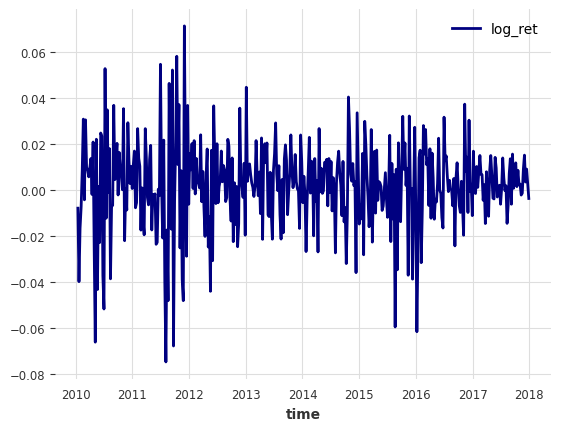

In [ ]:
returns.plot(color="navy") # plot returns

In [9]:
# Fit RF on returns
rf = RandomForestModel(
    lags=52,
    output_chunk_length=h,
    n_estimators=300,
    random_state=42
)
rf.fit(train_ret)

# Forecast returns
ret_forecast = rf.predict(n=h, series=train_ret)

<Axes: xlabel='time'>

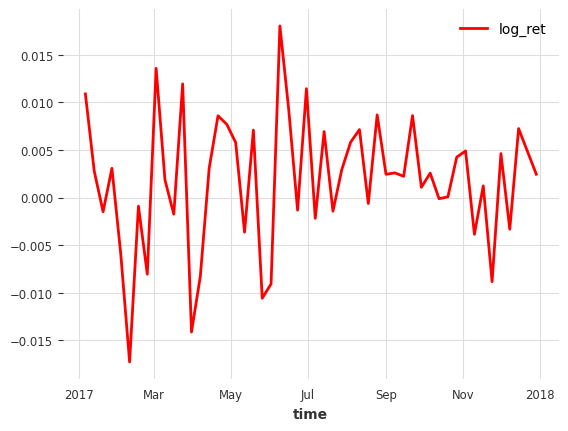

In [13]:
ret_forecast.plot(color="red") # plot returns

In [10]:
# Reconstruct price forecasts
# Formula: P̂_{t+1} = P_t * exp(r̂_{t+1}), recursively
last_price = weekly["Close"].loc[train_ret.end_time()]
pred_prices = []
curr_price = last_price
for r in ret_forecast.values().flatten():
    curr_price = curr_price * np.exp(r)
    pred_prices.append(curr_price)

pred_index = test_ret.time_index
price_forecast = TimeSeries.from_times_and_values(pred_index, np.array(pred_prices).reshape(-1,1))

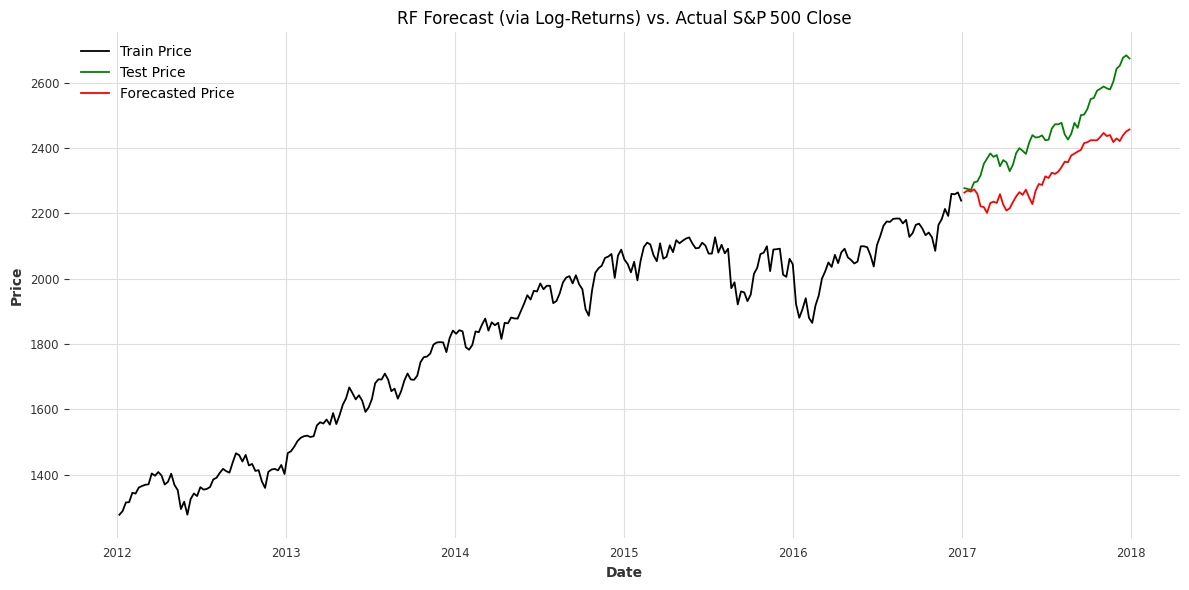

MAPE: 5.14%
MAE:  127.49
RMSE: 138.41


In [11]:
# Plot comparison (from 2014 onward)
train_slice = TimeSeries.from_series(weekly["Close"]).slice(pd.Timestamp("2012-01-01"), train_ret.end_time())

plt.figure(figsize=(12,6))
plt.plot(train_slice.time_index, train_slice.values(), label="Train Price")
plt.plot(test_ret.time_index, 
         weekly["Close"].loc[test_ret.time_index].values, 
         label="Test Price", color="green")
plt.plot(price_forecast.time_index, price_forecast.values(), 
         label="Forecasted Price", color="red")
plt.title("RF Forecast (via Log‑Returns) vs. Actual S&P 500 Close")
plt.xlabel("Date"); plt.ylabel("Price")
plt.legend(); plt.tight_layout(); plt.show()

# Evaluate on price‐level
actual_prices = TimeSeries.from_series(weekly["Close"].loc[test_ret.time_index])
print(f"MAPE: {mape(actual_prices, price_forecast):.2f}%")
print(f"MAE:  {mae(actual_prices,  price_forecast):.2f}")
print(f"RMSE: {rmse(actual_prices, price_forecast):.2f}")

### Log-return on 2023

In [3]:
sp500 = yf.Ticker("^GSPC")
df = sp500.history(start="2014-01-01", end="2024-01-01")[["Close"]].dropna()
df.index = pd.to_datetime(df.index).tz_localize(None)
all_bd = pd.date_range(df.index.min(), df.index.max(), freq="B")
df = df.reindex(all_bd)
df["Close"].ffill(inplace=True)
weekly = df["Close"].resample("W-FRI").last().to_frame()

C:\Users\USER\AppData\Local\Temp\ipykernel_22344\445042785.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Close"].ffill(inplace=True)


In [4]:
# Build a Darts TimeSeries of log‑returns
# log_ret_t = ln(P_t / P_{t‑1})
weekly["log_ret"] = np.log(weekly["Close"] / weekly["Close"].shift(1))
returns = TimeSeries.from_series(weekly["log_ret"].dropna(), freq="W")
returns = fill_missing_values(returns)

# Train/test split on returns
train_ret, test_ret = returns.split_before(pd.Timestamp("2023-01-01"))
h = len(test_ret)

In [5]:
# Fit RF on returns
rf = RandomForestModel(
    lags=52,
    output_chunk_length=h,
    n_estimators=300,
    random_state=42
)
rf.fit(train_ret)

# Forecast returns
ret_forecast = rf.predict(n=h, series=train_ret)

In [6]:
# Reconstruct price forecasts
# Formula: P̂_{t+1} = P_t * exp(r̂_{t+1}), recursively
last_price = weekly["Close"].loc[train_ret.end_time()]
pred_prices = []
curr_price = last_price
for r in ret_forecast.values().flatten():
    curr_price = curr_price * np.exp(r)
    pred_prices.append(curr_price)

pred_index = test_ret.time_index
price_forecast = TimeSeries.from_times_and_values(pred_index, np.array(pred_prices).reshape(-1,1))

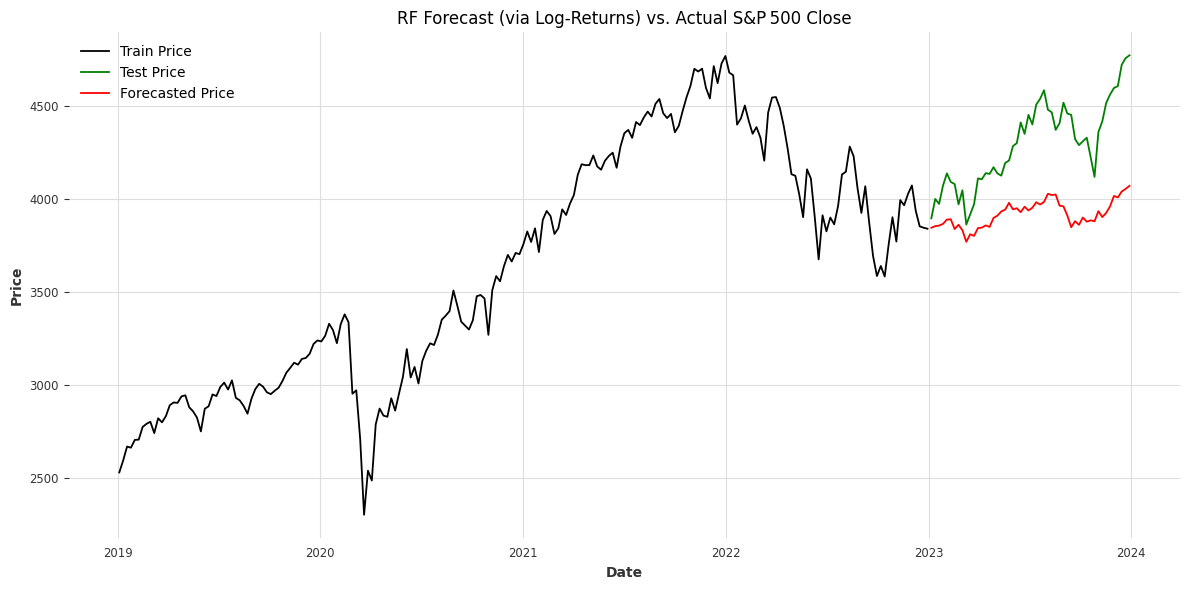

MAPE: 8.53%
MAE:  374.07
RMSE: 412.69


In [7]:
# Plot comparison (from 2014 onward)
train_slice = TimeSeries.from_series(weekly["Close"]).slice(pd.Timestamp("2019-01-01"), pd.Timestamp("2022-12-31"))

plt.figure(figsize=(12,6))
plt.plot(train_slice.time_index, train_slice.values(), label="Train Price")
plt.plot(test_ret.time_index, 
         weekly["Close"].loc[test_ret.time_index].values, 
         label="Test Price", color="green")
plt.plot(price_forecast.time_index, price_forecast.values(), 
         label="Forecasted Price", color="red")
plt.title("RF Forecast (via Log‑Returns) vs. Actual S&P 500 Close")
plt.xlabel("Date"); plt.ylabel("Price")
plt.legend(); plt.tight_layout(); plt.show()

# Evaluate on price‐level
actual_prices = TimeSeries.from_series(weekly["Close"].loc[test_ret.time_index])
print(f"MAPE: {mape(actual_prices, price_forecast):.2f}%")
print(f"MAE:  {mae(actual_prices,  price_forecast):.2f}")
print(f"RMSE: {rmse(actual_prices, price_forecast):.2f}")

### Backtest on 2023 and 2024